<a href="https://colab.research.google.com/github/marcosmedvescig/thesis_survival_models_for_predicting_churn/blob/master/model_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Evaluation

## Install libraries

Note: After installing the libraries for the first time restart the runtime for the new versions of the library to be loaded.

In [ ]:
## Install libraries
!pip install pysurvival=='0.1.2'
!pip install scikit-survival=='0.13.1'
!pip install osqp=='0.5.0'

     |████████████████████████████████| 4.8MB 5.5MB/s 
  Created wheel for pysurvival: filename=pysurvival-0.1.2-cp36-cp36m-linux_x86_64.whl size=3774858 sha256=368c8abf78924638b4cbcdecc165deb7900bfe7ecbf9320927172b313f0715e5
  Stored in directory: /root/.cache/pip/wheels/6c/23/e8/6feb0c4432219666bdd5d33828d7d9f429c4726f34c6fa8061
  Created wheel for progressbar: filename=progressbar-2.5-cp36-none-any.whl size=12074 sha256=124d02b2dd5e13a027ebcd958b127721487baa897c1b3b3be37e99f86195d38e
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built pysurvival progressbar
     |████████████████████████████████| 1.8MB 4.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 153kB 33.4MB/s 
  Created wheel for scikit-survival: filename=scikit_survival-0.13.1-cp36-cp36m-linux_x86_64.whl size=4119278 sha256=7f32d

## Custom Functions

In [ ]:
import numpy as np
import pandas as pd
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import integrated_brier_score
from sksurv.metrics import cumulative_dynamic_auc

def evaluate_model(model,X_train,T_train, E_train,X_test,T_test,E_test,
                   c_index=True,ibs=True,c_auc=True):

    # c-index
    if c_index:
        from pysurvival.utils.metrics import concordance_index
        c_index = concordance_index(model, X_test, T_test, E_test)
        print('c-index: {0:5.4f}'.format(c_index))
    else:
        c_index=0

    # ibs
    if ibs:        
        from pysurvival.utils.display import integrated_brier_score
        ibs = integrated_brier_score(model, X_test, T_test, E_test, t_max=200,
                    figure_size=(20, 6.5) )
        print('IBS: {0:5.4f}'.format(ibs))
    else:
        ibs=1

    # cumulative_auc
    if c_auc:
        from sksurv.metrics import cumulative_dynamic_auc

        train = np.array([(e,t) for e,t in zip(E_train,T_train)],dtype=[('event', 'bool_'),('time','int_')])
        test = np.array([(e,t) for e,t in zip(E_test,T_test)],dtype=[('event', 'bool_'),('time','int_')])

        # auc does not support inf risk so we replace with a really large value
        risk = model.predict_risk(X_test)
        risk = np.where(risk == np.inf,100,risk)

        auc_time_list,mean_auc = cumulative_dynamic_auc(train, test, risk, [100,150,300,500], tied_tol=1e-08)
        print('AUC: {0:5.4f}'.format(mean_auc))
    else:
        mean_auc=0

    #return results
    results = pd.DataFrame({'c_index':[c_index],
                                'ibs':[ibs],
                                'mean_auc':[mean_auc]})
    return results

## Load Data

In [ ]:
import pandas as pd
import numpy as np
import os

PROJECT_FOLDER = 'drive/My Drive/MiM + Analytics/Thesis/code_v2/'

# Open dataset
raw_data = pd.read_csv(PROJECT_FOLDER+'churn_data_anonymized_20200718.csv')
raw_data.rename(columns={'survival_days': 'time', 'status': 'event'},inplace=True)

raw_data.head()

,store_id,time,event,country,max_segment,creation_platform,products_created,admin_visits,source,seller_probability,tx,gmv_usd
0,1842269723731683560,261,1,A,B,A,-0.080154,-0.161978,I,1.014303,-0.042809,-0.071061
1,4773050910207726165,107,1,A,C,A,0.012447,0.566017,I,-0.214408,-0.076793,-0.092084
2,4171477716070775996,102,0,C,A,A,-0.075205,2.295003,A,-0.467481,0.602888,0.209250
3,-558102186785033374,101,1,C,C,A,-0.078033,-0.935472,A,-0.574383,-0.110777,-0.106463
4,-2987486431769169084,444,0,A,B,A,-0.063189,0.611516,I,1.614260,-0.099449,-0.103126


## Create Train, Test and Eval datasets

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Remove observations according to EDA

raw_data = raw_data[raw_data['time']>=0]
raw_data = raw_data[raw_data['products_created'] <= (raw_data['products_created'].mean() + 3 * raw_data['products_created'].std())]
raw_data = raw_data[raw_data['admin_visits'] <= (raw_data['admin_visits'].mean() + 3 * raw_data['admin_visits'].std())]
raw_data = raw_data[raw_data['tx'] <= (raw_data['tx'].mean() + 3 * raw_data['tx'].std())]
raw_data = raw_data[raw_data['gmv_usd'] <= (raw_data['gmv_usd'].mean() + 3 * raw_data['gmv_usd'].std())]

raw_data.reset_index(drop=True,inplace=True)

# Defining the features

X = pd.get_dummies(raw_data.drop(['store_id','time', 'event'], axis=1))
T = raw_data['time']
E = raw_data['event']

## Create evaluation set, 70% of the raw_data.
index_train_test, index_eval = train_test_split( range(len(raw_data)), test_size = 0.7, random_state = 2020)

# Creating the X, T and E input
X_train_test = X.loc[index_train_test].reset_index( drop = True )
X_eval  = X.loc[index_eval].reset_index( drop = True )

T_train_test = T.loc[index_train_test].reset_index( drop = True )
T_eval  = T.loc[index_eval].reset_index( drop = True )

E_train_test = E.loc[index_train_test].reset_index( drop = True )
E_eval  = E.loc[index_eval].reset_index( drop = True )


## Create train and test set, 30% of the raw_data.
index_train, index_test = train_test_split( range(len(X_train_test)), test_size = 0.25, random_state = 2020)

# Creating the X, T and E input
X_train = X_train_test.loc[index_train].reset_index( drop = True )
X_test  = X_train_test.loc[index_test].reset_index( drop = True )

T_train = T_train_test.loc[index_train].reset_index( drop = True )
T_test  = T_train_test.loc[index_test].reset_index( drop = True )

E_train = E_train_test.loc[index_train].reset_index( drop = True )
E_test  = E_train_test.loc[index_test].reset_index( drop = True )

## Model Evaluation

### Train the model

In [ ]:
from pysurvival.models.survival_forest import RandomSurvivalForestModel
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import integrated_brier_score
import pandas as pd

#Creating an instance of the Conditional model and fitting the data.

## Build the model
model = RandomSurvivalForestModel(num_trees=50)
model.fit(X_train, T_train, E_train,
        max_features="sqrt", max_depth=20, min_node_size=5)

RandomSurvivalForestModel

### Feature Importance

In [ ]:
# Computing feature importance
feature_importance = model.variable_importance_table
feature_importance.head(10)

,feature,importance,pct_importance
0,max_segment_C,9.967821,0.207265
1,seller_probability,5.313150,0.110478
2,max_segment_D,4.539613,0.094394
3,max_segment_A,4.431988,0.092156
4,max_segment_B,3.884639,0.080775
5,source_I,3.754926,0.078078
6,gmv_usd,3.276805,0.068136
7,admin_visits,3.234531,0.067257
8,tx,2.959598,0.061540
9,country_C,1.523575,0.031680


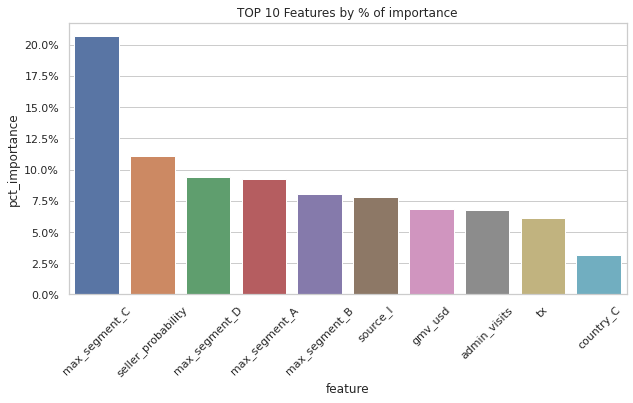

In [ ]:
# feature_importance.plot.bar(x='feature', y='pct_importance', rot=0);

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

plt.figure(figsize=(10,5))

# Multiply 100 to make it a percentage.
feature_importance['pct_importance'] = feature_importance['pct_importance']*100

ax = sns.barplot(x='feature', y='pct_importance', data=feature_importance[:10])
ax.set_title('TOP 10 Features by % of importance')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_xticklabels(ax.get_xticklabels(),rotation=45);

#### Compare survival functions for max_segment feature


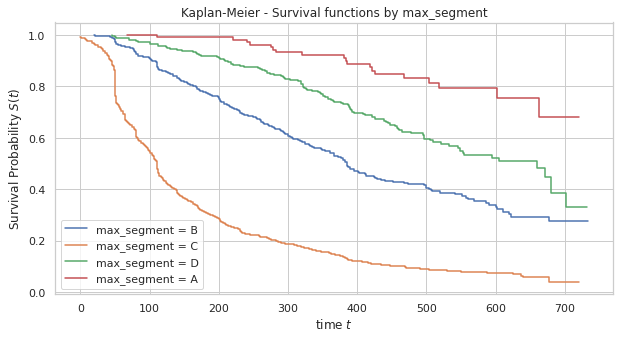

In [ ]:
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

plt.figure(figsize=(10,5))

raw_data['event'] = raw_data['event'].astype(bool)

for max_segment in ['B', 'C', 'D', 'A']:
    mask_segment = raw_data['max_segment'] == max_segment
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(
        raw_data['event'][mask_segment],
        raw_data['time'][mask_segment])
    
    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="max_segment = %s" % max_segment)

plt.ylabel("Survival Probability $S(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")
plt.title('Kaplan-Meier - Survival functions by max_segment');

### Evaluate the model on the 3 key metrics

c-index: 0.7439


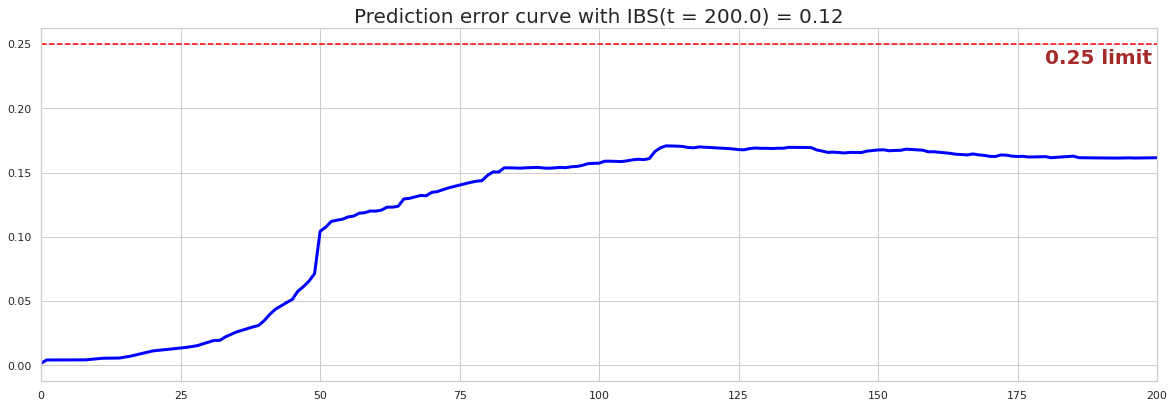

IBS: 0.1226
AUC: 0.8419
c-index: 0.7525


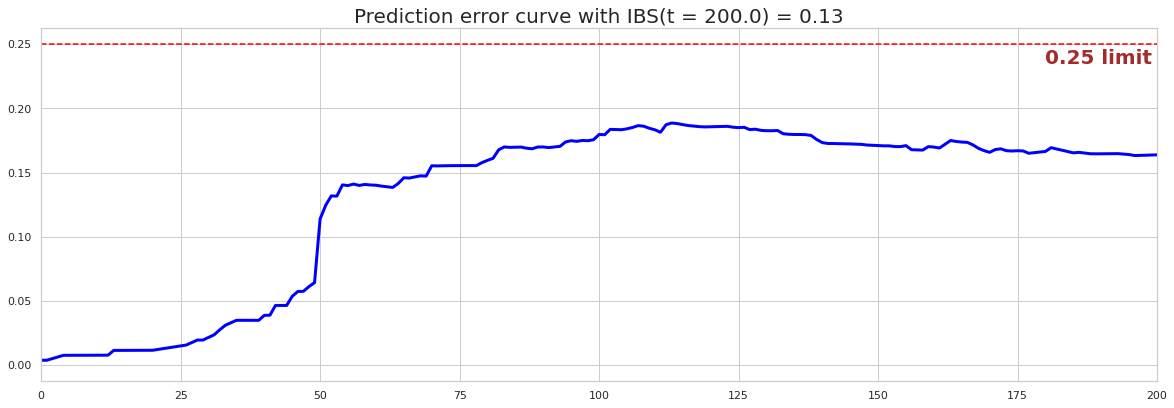

IBS: 0.1328
AUC: 0.8394
c-index: 0.7277


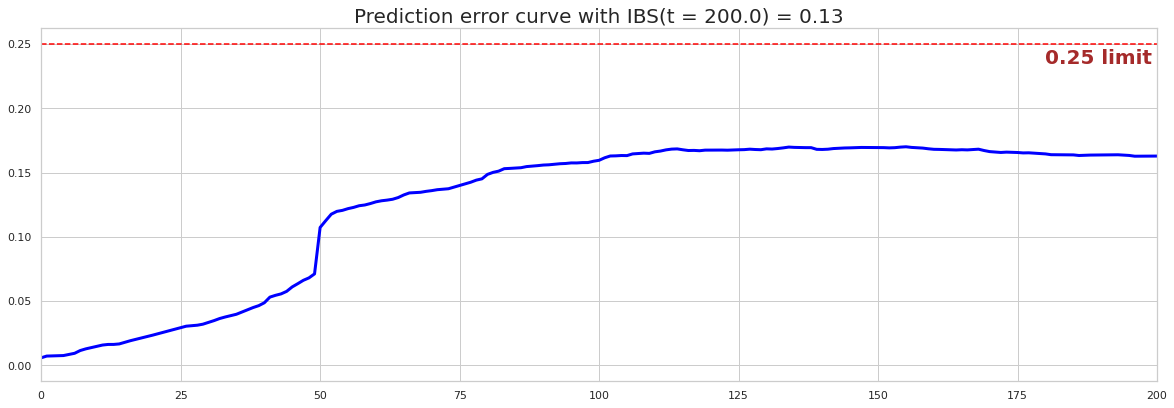

IBS: 0.1275
AUC: 0.8231


In [ ]:
import pandas as pd

results = pd.DataFrame()

# Train data
tmp_results = evaluate_model(model,X_train,T_train,E_train,X_train,T_train,E_train)
tmp_results['data'] = 'train'
results = pd.concat([results,tmp_results])

# Test data
tmp_results = evaluate_model(model,X_train,T_train,E_train,X_test,T_test,E_test)
tmp_results['data'] = 'test'
results = pd.concat([results,tmp_results])

# Evaluation data
tmp_results = evaluate_model(model,X_train,T_train,E_train,X_eval,T_eval,E_eval)
tmp_results['data'] = 'eval'
results = pd.concat([results,tmp_results])

In [ ]:
# Show results
results.head()

,c_index,ibs,mean_auc,data
0,0.776406,0.113655,0.858653,train
0,0.748179,0.131370,0.834407,test
0,0.730315,0.126085,0.828105,eval


### Evaluate model on predictions (RMSE)

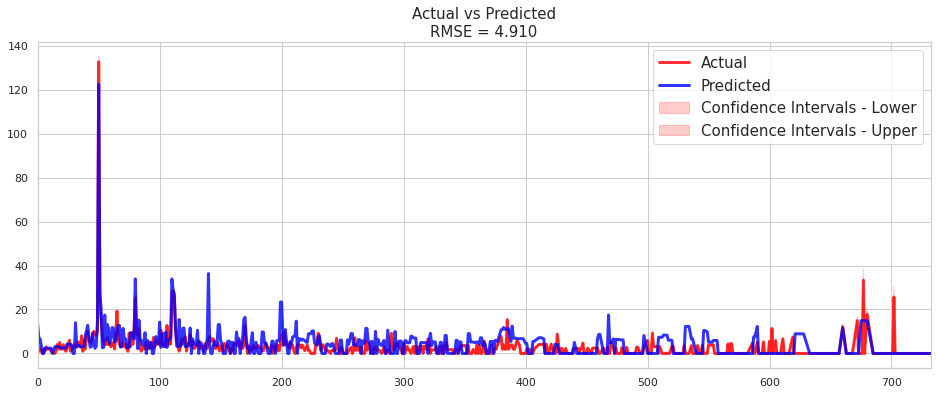

In [ ]:
from pysurvival.utils.display import compare_to_actual

results = compare_to_actual(model, X_eval, T_eval, E_eval,
                            is_at_risk = False,  figure_size=(16, 6),
                            metrics = ['rmse'])